## Goodreads Book Recommender

#### **Introduction**

This notebook generates book recommendations using two methods: collabortive filtering based on reader similarity and collaborative filtering based on predicted book ratings. The former uses KNN while the latter uses two forms of matrix factorization - first by singular value decomposition (SVD) and next by gradient descent using alternating least squares (ALS). 

Book and user ratings data come from the [Goodreads Book Graph Datasets](https://github.com/MengtingWan/goodreads]) produced by Mengting Wan, Rishabh Misra, Ndapa Nakashole, and Julian McAuley at UCSD. It has been imported, cleaned, and preprocessed in [00_prep_goodreads_data.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/00_prep_goodreads_data.ipynb). Genres, which are important for filtering recommendations but missing from the UCSD dataset, are inferred by topic modeling via latent dirichlet allocation (LDA) on book descriptions in [01_infer_genres.ipynb](https://github.com/mraottth/projects/blob/main/Goodreads%20Book%20Recommender/01_infer_genres.ipynb).

The target reader, for whom recommendations are being made in this notebook, is myself. To substitute your own Goodreads data and get personalized recommendations, go to the [Import/Export page](https://www.goodreads.com/review/import) on your Goodreads profile, download your books, and save as ```./Web App/data/goodreads_library_export.csv``` 

#### **Contents**

**Part 0: Preprocessing**
- 0.1 - Load and Prepare Data
- 0.1 - Write Functions to Process Recommendations

**Part 1: Collaborative Filtering Based on Reader Similarity with KNN**
- 1.1 - Find Similar Readers
- 1.2 - Generate Recommendations

**Part 2: Collaborative Filtering Based on Predicted Ratings with Matrix Factorization**
- 2.1 - Factorize User-Rating Matrix with SVD
- 2.2 - Generate Recommendations by Predicting Ratings
- 2.3 - Matrix Factorization with Gradient Descen

## Part 0: Preprocessing

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Normalizer
from IPython.display import display
from scipy.sparse.linalg import svds
from skimage import io
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import AutoMinorLocator
from sparse_dot_mkl import dot_product_mkl

In [327]:
# Set global variable of "sparse" or "dense"
# "sparse" will have user-item matrix with all books, "dense" only those in df_books
SPARSITY = "dense" 

# Choose K for small med and large neighborhoods
SM, MD, LG = 150, 1000, 3000

# For books in my_books where there's a better book id to assign it for matching
ids_to_replace = {    
    40514364:25499718, # Children of Time
    40961621:347610, # King Leopold's Ghost
    33395538:32191710, # Astrophysics for People in a Hurry
    33854198:875808, # Man-Eaters Of Kumaon
    44767458:234225, # Dune
    25772375:234225 # Dune (export sometimes generates this ID)
}

### 0.1 - Load and Prepare Data

In [328]:
# Load df_books and genres
wd = os.getcwd()
df_books = pd.read_csv(wd + "/Web App/data/goodreads_books.csv")
df_inferred_genres = pd.read_csv(wd + "/Web App/data/inferred_genres.csv")
genre_descriptors = pd.read_csv(wd + "/Web App/data/inferred_genre_top_words.csv")

# Join genres to books
df_books = pd.merge(df_books, df_inferred_genres, how="left", on="book_id")

# Filter out kids books
df_books = df_books[df_books.loc[:,"children":"comic"].sum(axis=1) < 2]

In [329]:
# Load sparse_reviews from file
df_reviews = sparse.load_npz(wd + "/Web App/data/user_reviews.npz")

# Load user (rows) and book (cols) indices
user_index = pd.read_csv(wd + "/Web App/data/user_index_for_sparse_matrix.csv").rename(columns={"0":"user_id"})
book_index = pd.read_csv(wd + "/Web App/data/book_index_for_sparse_matrix.csv").rename(columns={"0":"book_id"})

In [330]:
# Create df_reviews that is less sparse than original
if SPARSITY == "dense":
    in_df_books = book_index["book_id"].isin(df_books["book_id"])
    book_index = book_index[in_df_books].reset_index().drop("index", axis=1)
    df_reviews = df_reviews[:, in_df_books]
print(f"User-Item Matrix: {df_reviews.shape[0]:,} readers by {df_reviews.shape[1]:,} books")    

User-Item Matrix: 245,119 readers by 315,354 books


In [331]:
# Load my goodreads history
my_books = pd.read_csv(wd + "/Web App/data/goodreads_library_export.csv")
# my_books["Title"].replace(titles_to_replace, inplace=True)
my_books["Book Id"].replace(ids_to_replace, inplace=True)

# Filter to books I've rated
my_books = my_books[["Book Id", "My Rating", "Title"]]\
    .rename(columns={"Book Id":"book_id", "My Rating":"rating", "Title":"title"}).query("rating > 0")
print(f"Target reader ratings: {my_books.shape[0]}")

# First match on book_id
my_books_1 = pd.merge(
                my_books, df_books[["book_id", "title"]], 
                how="inner", on="book_id", suffixes=["_mb","_dfb"]
            ).rename(columns={"title_dfb":"title"}).drop("title_mb", axis=1)
print(f"Matching on book_id: {my_books_1.shape[0]}")

# Next match on title
my_books_2 = pd.merge(
    my_books[~my_books["book_id"].isin(my_books_1["book_id"])], # not matched on id
    df_books[["book_id", "title", "ratings_count", "avg_rating"]], 
    how="inner", on="title", suffixes=["_mb","_dfb"]
    ).sort_values(["title", "ratings_count"], ascending=False)\
     .drop_duplicates(subset=["title"])\
     .rename(columns={"book_id_dfb":"book_id"})
print(f"Matching on title: {my_books_2[~my_books_2['book_id'].isin(my_books_1['book_id'])].shape[0]}")

# Concat matching on book_id and matching on title
my_books_3 = pd.concat([my_books_1, my_books_2[["book_id", "rating", "title"]]])\
               .drop_duplicates(subset="title")
print(f"Total matches: {my_books_3.shape[0]}, {(my_books_3.shape[0] / my_books.shape[0]):.2%} of total")

# Reshape to sparse matrix dimensions
my_books_4 = pd.merge(book_index, my_books_3, how="left", on="book_id").fillna(0.)
my_books = np.array(my_books_4["rating"]).reshape(1,-1)

# Add to sparse matrix
df_reviews = sparse.vstack([df_reviews, my_books])
df_reviews = sparse.csc_matrix(df_reviews)

# Normalize reviews within readers
norm = Normalizer()
row_norms = np.sqrt(np.sum(df_reviews.power(2), axis=1)) # save row norms to un-normalzie later
df_reviews = norm.fit_transform(df_reviews) 

Target reader ratings: 184
Matching on book_id: 100
Matching on title: 21
Total matches: 121, 65.76% of total


In [332]:
# Set target reader to make recommendations for
target = df_reviews.shape[0] - 1

#### 0.2 - Write Functions to Process Recommendations

In [333]:
# Function to use KNN to find similar users
def find_neighbors(n_neighbors, target_user, ratings_df, ind_books, books):

    # Instantiate KNN
    n_neighbors = n_neighbors

    nn_model = NearestNeighbors(
        metric="cosine",
        algorithm="auto",
        n_neighbors=n_neighbors,
        n_jobs=-1
    )

    # Fit to sparse matrix
    nn_model.fit(ratings_df)

    # Feed in user and get neighbors and distances
    reader = ratings_df[target,:].toarray()
    dists, neighbors = nn_model.kneighbors(reader, return_distance=True)

    similar_users = pd.DataFrame(
        [pd.Series(neighbors.reshape(-1)), pd.Series(dists.reshape(-1))]).T.rename(
            columns={0:"user", 1:"distance"}
    )

    # Get all books read by similar users
    book_ind = []
    book_rat = []
    uid = []
    target_user_books = []
    target_user_book_rat = []
    for nt in similar_users.itertuples():
        user = ratings_df[int(nt.user),:].toarray()
        book_inds = np.where(user[0] > 0)[0]
        ratings = user[0][np.where(user[0] > 0)[0]]
        for i in range(len(book_inds)):        
            book_ind.append(book_inds[i])
            book_rat.append(ratings[i] * float(row_norms[int(nt.user)])) 
            uid.append(nt.user)    
            if nt.distance < 0.000000001:
                target_user_books.append(book_inds[i])
                target_user_book_rat.append(ratings[i])

    neighbor_user_ratings = pd.DataFrame([uid, book_ind, book_rat]).T.rename(
                                columns={0:"uid",1:"book_index",2:"user_rating"}
                            )

    # Join overall rating for each book
    neighbor_user_ratings = pd.merge(
                                ind_books.reset_index(), neighbor_user_ratings, 
                                how="inner", left_on="index", right_on="book_index"
                            )
    neighbor_user_ratings = pd.merge(neighbor_user_ratings, books, how="inner", on="book_id")

    # Filter out books target reader has already read
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["book_index"].isin(target_user_books)]
    neighbor_user_ratings.drop(["index"], axis=1, inplace=True)

    # Filter out later volumes in series using regex pattern
    regex1 = r"#(?:[2-9]|[1-9]\d+)"
    regex2 = r"Vol. (?:[0-9]|[1-9]\d+)"
    regex3 = r"Volume (?:[0-9]|[1-9]\d+)"
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex1)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex2)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains(regex3)]
    neighbor_user_ratings = neighbor_user_ratings[~neighbor_user_ratings["title"].str.contains("#1-")]

    # View target user's ratings
    target_user_ratings = pd.DataFrame(
                            [target_user_books, target_user_book_rat]).T.rename(
                                columns={0:"book_index",1:"user_rating"}
                        )
    target_user_ratings = pd.merge(
                            ind_books.reset_index(), target_user_ratings,
                            how="inner", left_on="index", right_on="book_index"
                        )
    target_user_ratings = pd.merge(target_user_ratings, books, how="inner", on="book_id")    

    return neighbor_user_ratings, target_user_ratings, dists

In [334]:
# Function to show top recs for each genre
def show_top_recs_by_genre(
        target, others, preds=None, how=["KNN", "MF"], whose_genres=["target", "neighbors"], 
        n_genres=5, min_score=3.75, min_ratings=100, n_recs=20, write_to_excel=False):

    if whose_genres == "target":
        genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))
    else:
        genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0).sort_values(ascending=False))   

    others_ratings = others.groupby("book_id")["user_rating"].mean()\
                                                .reset_index()\
                                                .rename(columns={"user_rating":"similar_usr_avg"})

    genres = []
    results = []
    # Loop through genres in descending relevance order and print top recs
    for genre in genre_ranking.index[0:n_genres]:        
        
        g = float(genre[6:])
        if how == "KNN":
            highest_rated_recs_genre = others.query("main_genre == @g")\
                .groupby(["title", "avg_rating", "ratings_count", "year", "url", "book_id"])["uid"]\
                .count().reset_index().sort_values(by=["avg_rating", "book_id"], ascending=False)
        
        elif how == "MF":
            highest_rated_recs_genre = preds.query("main_genre == @g").sort_values(by="predicted_rating", 
                                                                                   ascending=False)                

        highest_rated_recs_genre = highest_rated_recs_genre.query(
                                        "ratings_count > @min_ratings & avg_rating > @min_score"
                                    )
        
        highest_rated_recs_genre = pd.merge(highest_rated_recs_genre, others_ratings, how="left", on="book_id")
        
        highest_rated_recs_genre["similar_usr_avg"] = highest_rated_recs_genre["similar_usr_avg"].round(2)
        
        cols = ["title", "avg_rating", "similar_usr_avg", "ratings_count", "year", "url"]
        highest_rated_recs_genre = highest_rated_recs_genre[cols]

        # Print genre name and descriptor
        for nt in genre_descriptors.itertuples():
            genre_rep = genre.replace("_"," ")
            if nt.genre_string[0:len(f"{genre}:")] == f"{genre_rep}:":
                gs = (nt.genre_string)
        
        genres.append(gs)
        results.append(highest_rated_recs_genre.head(50))

        print(gs)
        display(highest_rated_recs_genre.head(n_recs))
        print("_____\n")
    
    # Write to excel if keyword set
    path = (wd + "/Web App/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                
                pd.DataFrame(genres).rename(columns={0:"Genres"})\
                    .to_excel(writer, sheet_name="Genre Meanings", index=False)
                
                for i in range(len(results)):
                    results[i].to_excel(writer, sheet_name=f"{genres[i].split(':')[0]} Recs", index=False)
        writer.close

In [335]:
# Function to show most popular books among similar readers
def neighbors_most_popular(others, n=20, min_ratings=100, min_score=3.75, write_to_excel=False):
    
    others = pd.merge(others.groupby("book_id")["user_rating"].mean()\
                            .reset_index().rename(columns={"user_rating":"similar_usr_avg"}),
                      others,
                      on="book_id")
    others["similar_usr_avg"] = others["similar_usr_avg"].round(2)

    popular_recs = others.query("ratings_count > @min_ratings & avg_rating > @min_score")\
        .groupby(["title", "avg_rating", "similar_usr_avg", "ratings_count", "year", "url"])["book_id"]\
        .count().reset_index().sort_values(by=["book_id", "avg_rating"], ascending=False)\
        .nlargest(n, "book_id").rename(columns={"book_id":"%_similar_usr_read"})

    popular_recs["%_similar_usr_read"] = (popular_recs["%_similar_usr_read"] / 
                                            others["uid"].nunique()).map('{:.1%}'.format)
    
    # Write to excel if keyword set
    path = (wd + "/Web App/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                popular_recs.to_excel(writer, sheet_name="Popular Among Similar Readers", index=False)
                
        writer.close

    return popular_recs[
        ["title","avg_rating","similar_usr_avg", "ratings_count","year","%_similar_usr_read","url"]
    ]

In [336]:
# Function to show top rated among similar readers
def neighbors_top_rated(others, n=20, min_ratings=100, min_score=3.75, write_to_excel=False):

    others = pd.merge(others.groupby("book_id")["user_rating"].mean()\
                            .reset_index().rename(columns={"user_rating":"similar_usr_avg"}),
                      others,
                      on="book_id")
    others["similar_usr_avg"] = others["similar_usr_avg"].round(2)
    
    min_neighbor_ratings = np.max([others["uid"].nunique() / 250, 5])

    highest_rated_recs = others.query(
                "ratings_count > @min_ratings & avg_rating > @min_score & YA == 0")\
        .groupby(["title", "avg_rating", "similar_usr_avg", "ratings_count", "year", "url"])["uid"]\
        .count().reset_index().sort_values(by=["similar_usr_avg", "avg_rating", "uid"], ascending=False)\
        .query("uid >= @min_neighbor_ratings")\
        .nlargest(n, "similar_usr_avg").drop(columns="uid")
    
    # Write to excel if keyword set
    path = (wd + "/Web App/data/book_recs.xlsx")
    if write_to_excel == True:
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                highest_rated_recs.to_excel(writer, sheet_name="Top Rated Among Similar Readers", index=False)
                
        writer.close

    return highest_rated_recs

In [337]:
# Function to plot neighbors' and target's top genres
def plot_top_genres(others, target):

    # Get genre rankings for target and neighbors
    target_genre_ranking = pd.DataFrame(target.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})
    target_genre_ranking = target_genre_ranking.div(target_genre_ranking.sum(axis=0), axis=1)

    neighbor_genre_ranking = pd.DataFrame(others.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"neighbor"})
    neighbor_genre_ranking = neighbor_genre_ranking.div(neighbor_genre_ranking.sum(axis=0), axis=1)

    genre_rankings = pd.merge(
            target_genre_ranking, neighbor_genre_ranking, left_index=True, right_index=True
            ).reset_index()

    # Plot target genre pref
    fig, ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='target',
        s=150,
        edgecolors='black',
        color="mediumslateblue",
        linewidths = 0.75,
        label='Target Reader',
        zorder=2,
        )

    # Plot neighbors genre pref
    sns.scatterplot(
        data=genre_rankings,
        y='index',
        x='neighbor',
        label='Similar Readers',
        color="darkgray",
        s=150,
        zorder=3
        )

    # Iterate through each genre and plot line connecting 2 points
    for ind in list(genre_rankings['index']):
    
        # Plot line connecting points
        plt.plot([genre_rankings[genre_rankings['index']==ind]['target'],
                    genre_rankings[genre_rankings['index']==ind]['neighbor']],
                    [ind, ind],
                    color='#565A5C',
                    alpha=0.2,                    
                    # linestyle=(0, (1,1)),
                    linewidth=6.5,
                    zorder=1
                    )

    # Set chart details
    plt.legend(bbox_to_anchor=(1,1), loc="upper left", borderpad=1)
    ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
    ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
    plt.xlabel("Genre preference")
    plt.ylabel(None)
    plt.title('Top Genres for Target Reader and Similar Readers', fontsize=14)
    plt.show()

In [338]:
def display_top_books(preds, books, target_ratings):
    """
    Plots book cover images for top recommendations in top 5 genres

    Args:
        preds: prediction df yielded by get_recs()
        books: dataframe with all book info
        target_ratings: target user's book ratings

    Returns:
        None
    """
    # Get image_url for top preds
    plot_pred = pd.merge(
                    preds[["book_id", "predicted_rating"]], 
                    books[["book_id", "image_url", "main_genre"]], 
                    on="book_id"
                )

    # For each of the top 10 genres, get top 5 books
    top_genres = pd.DataFrame(target_ratings.loc[:, "Genre_1":].sum(axis=0)\
                                            .sort_values(ascending=False)).rename(columns={0:"target"})[0:5]

    # Function to turn image url into image 
    def getImage(path, zoom=0.3):
        return OffsetImage(io.imread(path), zoom=zoom)

    # Plot
    fig, ax = plt.subplots(figsize=(13,7))
    for i in range(len(top_genres)): # For each of top genres
        genre = top_genres.index[i]
        g = float(genre[6:]) # Get genre number
        
        # Slice plot pred to genre and valid image url
        books_to_plot = plot_pred[ 
            (plot_pred["main_genre"] == g) & (plot_pred["image_url"].str.contains("images.gr-"))
            ].head(5)
        
        paths = [url for url in books_to_plot["image_url"]] # Get image urls
        x = [i * 10 + 10 for x in range(5)] # Set genre bucket
        y = [y for y in books_to_plot["predicted_rating"]] # get predicted rating as y

        # Plot
        ax.scatter(x,y,alpha=0) 

        # Plot image at xy
        for x0, y0, path in zip(x, y, paths):
            ab = AnnotationBbox(getImage(path), (x0 + np.random.uniform(-3.5,3.5), y0), frameon=True, pad=0.3)
            ax.add_artist(ab)
        
    plt.ylabel("Recommendation Strength", fontsize=12)
    plt.xlabel("\nGenre Grouping", fontsize=12)
    plt.title("Top Recommendations by Genre", y=1.02, fontsize=14)
    plt.xlim((5, 55))
    ax.spines[['right', 'top', 'left']].set_visible(False)
    plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)
    ax.yaxis.set_ticklabels([])
    ax.yaxis.grid(True, alpha=0.3) # Create y gridlines
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.xaxis.grid(which="minor", visible=True, alpha=0.8) # Create x gridlines
    plt.show()

## Part 1 - Collaborative Filtering Based on Reader Similarity with KNN

In this section, we use K-Nearest Neighbors (KNN) to find the readers most similar to our target reader. Each reader's ratings on all books in the dataset are encoded as vectors where unread books are given a value of 0. We use cosine similarity to find the users whose ratings are most similar to the target and then filter among their books to find the most popular and highest rated.

### 1.1 - Find Similar Readers

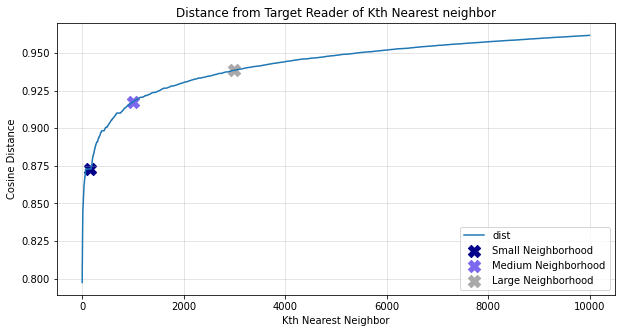

In [339]:
# Take a very large neighborhood to see how reader similarity decreases with K
n, t, dists = find_neighbors(10000, target, df_reviews, book_index, df_books)

# Plot distance by kth closest neighbor
fig, ax = plt.subplots(figsize=(10,5))
pd.DataFrame(dists.T).rename(columns={0:"dist"})[1:10000].plot(ax=ax)
plt.title("Distance from Target Reader of Kth Nearest neighbor")
plt.xlabel("Kth Nearest Neighbor")
plt.ylabel("Cosine Distance")
ax.yaxis.grid(True, alpha=0.4) # Create y gridlines
ax.xaxis.grid(True, alpha=0.4) # Create x gridlines
plt.scatter(SM, dists[0,SM], color="darkblue", marker="X", label="Small Neighborhood", s=150)
plt.scatter(MD, dists[0,MD], color="mediumslateblue", marker="X", label="Medium Neighborhood", s=150)
plt.scatter(LG, dists[0,LG], color="darkgray", marker="X", label="Large Neighborhood", s=150)
plt.legend()
plt.show()

In [340]:
# Perform KNN on user rating matrix
sm_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        SM, target, df_reviews, book_index, df_books)

# Find med number of similar users than before to get broader pool of potentially relevant books
med_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                    MD, target, df_reviews, book_index, df_books)

# Find larger number of similar users 
lg_neighborhood_ratings, target_user_ratings, d = find_neighbors(
                                                        LG, target, df_reviews, book_index, df_books)

print(f"Small neighborhood contains {sm_neighborhood_ratings['book_index'].nunique():,} books, " \
        f"{sm_neighborhood_ratings['uid'].nunique():,} readers")
print(f"Medium neighborhood contains {med_neighborhood_ratings['book_index'].nunique():,} books, " \
        f"{med_neighborhood_ratings['uid'].nunique():,} readers")
print(f"Large neighborhood contains {lg_neighborhood_ratings['book_index'].nunique():,} books, " \
        f"{lg_neighborhood_ratings['uid'].nunique():,} readers")

Small neighborhood contains 564 books, 60 readers
Medium neighborhood contains 6,300 books, 847 readers
Large neighborhood contains 20,259 books, 2,786 readers


<a id='Part1.2'></a>
### 1.2 - Generate Recommendations

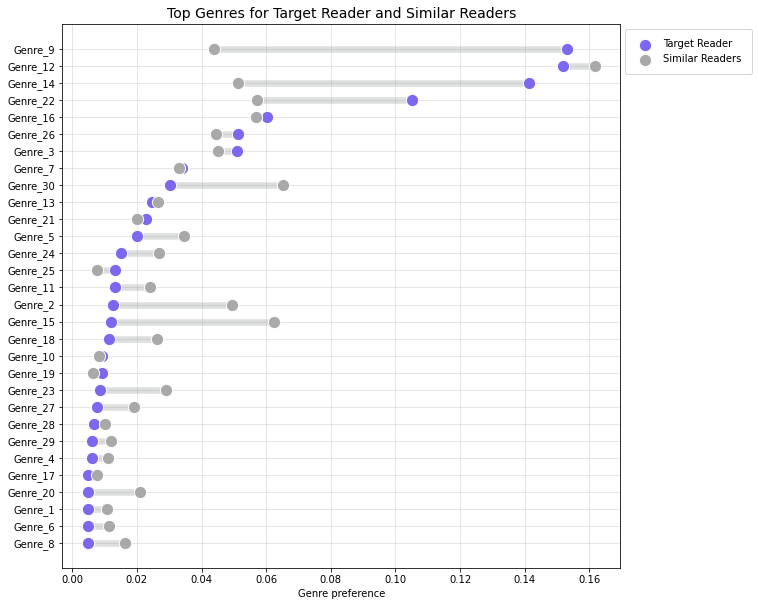

In [341]:
# Show top genres
plot_top_genres(sm_neighborhood_ratings, target_user_ratings)

In [342]:
# View most popular books among neighbors
neighbors_most_popular(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,similar_usr_avg,ratings_count,year,%_similar_usr_read,url
212,Ready Player One,4.31,4.33,376328.0,2011.0,15.0%,https://www.goodreads.com/book/show/9969571-re...
355,The Martian,4.39,4.17,435440.0,2014.0,10.0%,https://www.goodreads.com/book/show/18007564-t...
193,"Old Man's War (Old Man's War, #1)",4.23,3.67,100702.0,2007.0,10.0%,https://www.goodreads.com/book/show/51964.Old_...
79,Dark Matter,4.10,3.33,75794.0,2016.0,10.0%,https://www.goodreads.com/book/show/27833670-d...
408,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.60,151473.0,2010.0,8.3%,https://www.goodreads.com/book/show/7235533-th...
362,The Name of the Wind (The Kingkiller Chronicle...,4.55,4.60,416634.0,2007.0,8.3%,https://www.goodreads.com/book/show/186074.The...
344,"The Hunger Games (The Hunger Games, #1)",4.34,3.40,4899965.0,2008.0,8.3%,https://www.goodreads.com/book/show/2767052-th...
20,All the Light We Cannot See,4.31,4.50,498685.0,2014.0,6.7%,https://www.goodreads.com/book/show/18143977-a...
163,"Leviathan Wakes (The Expanse, #1)",4.20,4.00,72492.0,2011.0,6.7%,https://www.goodreads.com/book/show/8855321-le...
247,Snow Crash,4.02,3.25,179029.0,2000.0,6.7%,https://www.goodreads.com/book/show/830.Snow_C...


In [343]:
# View highest rated books among similar readers
neighbors_top_rated(sm_neighborhood_ratings, 15, write_to_excel=False)

,title,avg_rating,similar_usr_avg,ratings_count,year,url
320,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.60,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
282,The Martian,4.39,4.17,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
157,"Old Man's War (Old Man's War, #1)",4.23,3.67,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
66,Dark Matter,4.10,3.33,75794.0,2016.0,https://www.goodreads.com/book/show/27833670-d...


In [344]:
# View highest rated books by each of the top genres
show_top_recs_by_genre(
    target=target_user_ratings, 
    others=sm_neighborhood_ratings, 
    how="KNN", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.75, 
    n_recs=15,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Josephine B Trilogy,4.45,4.0,132.0,2006.0,https://www.goodreads.com/book/show/1308176.Th...
1,The Godfather,4.36,4.0,259150.0,2002.0,https://www.goodreads.com/book/show/22034.The_...
2,"The Winds of War (The Henry Family, #1)",4.36,5.0,42658.0,2002.0,https://www.goodreads.com/book/show/21484.The_...
3,India After Gandhi: The History of the World's...,4.35,4.0,9652.0,2007.0,https://www.goodreads.com/book/show/356824.Ind...
4,A Thousand Splendid Suns,4.34,3.0,835172.0,2007.0,https://www.goodreads.com/book/show/128029.A_T...
5,On Writing: A Memoir of the Craft,4.31,4.0,135528.0,2002.0,https://www.goodreads.com/book/show/10569.On_W...
6,The Emperor of All Maladies: A Biography of Ca...,4.29,5.0,49534.0,2010.0,https://www.goodreads.com/book/show/7170627-th...
7,Bury My Heart at Wounded Knee: An Indian Histo...,4.21,5.0,41180.0,2001.0,https://www.goodreads.com/book/show/76401.Bury...
8,The Red Tent,4.16,4.0,428809.0,2005.0,https://www.goodreads.com/book/show/4989.The_R...
9,The Rise and Fall of the Third Reich: A Histor...,4.15,4.0,66924.0,1990.0,https://www.goodreads.com/book/show/767171.The...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,A Night Without Stars,4.41,5.00,1758.0,2016.0,https://www.goodreads.com/book/show/28530221-a...
1,The Martian,4.39,4.17,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
2,The Stand,4.34,2.00,449730.0,1978.0,https://www.goodreads.com/book/show/149267.The...
3,"We Are Legion (We Are Bob) (Bobiverse, #1)",4.30,3.67,17174.0,2016.0,https://www.goodreads.com/book/show/32109569-w...
4,Judas Unchained,4.30,4.50,21306.0,2005.0,https://www.goodreads.com/book/show/45244.Juda...
5,"This Book Is Full of Spiders: Seriously, Dude,...",4.26,3.00,294.0,2013.0,https://www.goodreads.com/book/show/17286949-t...
6,"Pandora's Star (Commonwealth Saga, #1)",4.24,4.00,1312.0,2006.0,https://www.goodreads.com/book/show/6136470-pa...
7,"Old Man's War (Old Man's War, #1)",4.23,3.67,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
8,Understand,4.22,4.00,869.0,2006.0,https://www.goodreads.com/book/show/7234685-un...
9,The Abyss Beyond Dreams,4.21,5.00,4944.0,2014.0,https://www.goodreads.com/book/show/20697413-t...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,On Tyranny: Twenty Lessons from the Twentieth ...,4.29,4.0,9145.0,2017.0,https://www.goodreads.com/book/show/33917107-o...
1,Our Revolution: A Future to Believe In,4.29,3.0,2430.0,2016.0,https://www.goodreads.com/book/show/31741420-o...
2,Elon Musk: Inventing the Future,4.24,3.0,63849.0,2015.0,https://www.goodreads.com/book/show/22543496-e...
3,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,5.0,11750.0,2015.0,https://www.goodreads.com/book/show/22535480-e...
4,Hun Sen’s Cambodia,4.20,3.0,105.0,2014.0,https://www.goodreads.com/book/show/21945075-h...
5,"Titan: The Life of John D. Rockefeller, Sr.",4.19,4.0,8970.0,2004.0,https://www.goodreads.com/book/show/16121.Titan
6,The Sleepwalkers: How Europe Went to War in 1914,4.18,4.0,3830.0,2012.0,https://www.goodreads.com/book/show/18669169-t...
7,"Blood Meridian, or the Evening Redness in the ...",4.18,5.0,72755.0,1992.0,https://www.goodreads.com/book/show/394535.Blo...
8,Daemon (Daemon #1),4.17,2.0,9355.0,2009.0,https://www.goodreads.com/book/show/6665847-da...
9,The Captain: The Journey of Derek Jeter,4.16,4.0,1085.0,2011.0,https://www.goodreads.com/book/show/9925251-th...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Behave: The Biology of Humans at Our Best and ...,4.40,5.00,830.0,2017.0,https://www.goodreads.com/book/show/31170723-b...
1,The Authoritarians,4.31,5.00,354.0,2006.0,https://www.goodreads.com/book/show/1971601.Th...
2,Stories of Your Life and Others,4.27,4.67,17769.0,2010.0,https://www.goodreads.com/book/show/223380.Sto...
3,Writing Great Fiction: Storytelling Tips and T...,4.24,4.00,381.0,2014.0,https://www.goodreads.com/book/show/24235595-w...
4,The Hero With a Thousand Faces,4.24,4.00,18378.0,1972.0,https://www.goodreads.com/book/show/588138.The...
5,Dear Data,4.22,2.00,227.0,2016.0,https://www.goodreads.com/book/show/28465052-d...
6,Meditations,4.20,5.00,45727.0,2006.0,https://www.goodreads.com/book/show/30659.Medi...
7,"The Diamond Age: or, A Young Lady's Illustrate...",4.19,4.00,62866.0,2000.0,https://www.goodreads.com/book/show/827.The_Di...
8,Guns,4.17,4.00,3687.0,2013.0,https://www.goodreads.com/book/show/17284577-guns
9,A Brief History of Time,4.13,4.00,173373.0,1998.0,https://www.goodreads.com/book/show/3869.A_Bri...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Pragmatic Programmer: From Journeyman to M...,4.31,5.0,9737.0,1999.0,https://www.goodreads.com/book/show/4099.The_P...
1,Your Deceptive Mind: A Scientific Guide to Cri...,4.30,4.0,1005.0,2012.0,https://www.goodreads.com/book/show/13562148-y...
2,The Dictator's Handbook: Why Bad Behavior is A...,4.27,3.0,2497.0,2011.0,https://www.goodreads.com/book/show/11612989-t...
3,Turn the Ship Around!: A True Story of Turning...,4.26,2.0,2684.0,2013.0,https://www.goodreads.com/book/show/16158601-t...
4,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,4.0,27705.0,2014.0,https://www.goodreads.com/book/show/18077903-c...
5,The Hard Thing About Hard Things: Building a B...,4.20,2.0,20745.0,2014.0,https://www.goodreads.com/book/show/18176747-t...
6,Deep Work: Rules for Focused Success in a Dist...,4.19,3.0,15605.0,2016.0,https://www.goodreads.com/book/show/25744928-d...
7,Your Best Brain: The Science of Brain Improvement,4.18,3.0,261.0,2014.0,https://www.goodreads.com/book/show/23626805-y...
8,Influence: The Psychology of Persuasion,4.18,5.0,47682.0,2006.0,https://www.goodreads.com/book/show/28815.Infl...
9,Work Rules!: Insights from Inside Google That ...,4.16,3.0,4902.0,2015.0,https://www.goodreads.com/book/show/22875447-w...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Gates of Fire: An Epic Novel of the Battle of ...,4.40,5.00,18299.0,2005.0,https://www.goodreads.com/book/show/1305.Gates...
1,"Shōgun (Asian Saga, #1)",4.37,5.00,106404.0,2009.0,https://www.goodreads.com/book/show/402093.Sh_gun
2,"Dawn of Wonder (The Wakening, #1)",4.35,1.00,13351.0,2015.0,https://www.goodreads.com/book/show/25451852-d...
3,The Emperor's Soul,4.33,5.00,35260.0,2012.0,https://www.goodreads.com/book/show/13578175-t...
4,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,4.00,123373.0,2006.0,https://www.goodreads.com/book/show/127455.The...
5,"Outlander (Outlander, #1)",4.21,5.00,531055.0,2005.0,https://www.goodreads.com/book/show/10964.Outl...
6,Elantris,4.17,4.00,1420.0,2011.0,https://www.goodreads.com/book/show/10803709-e...
7,"Elantris (Elantris, #1)",4.17,4.33,100115.0,2006.0,https://www.goodreads.com/book/show/68427.Elan...
8,"Assassin's Apprentice (Farseer Trilogy, #1)",4.14,2.00,133239.0,1996.0,https://www.goodreads.com/book/show/45107.Assa...
9,"Master and Commander (Aubrey & Maturin, #1)",4.11,4.00,31858.0,1990.0,https://www.goodreads.com/book/show/77430.Mast...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Man's Search for Meaning,4.33,3.5,179906.0,2006.0,https://www.goodreads.com/book/show/4069.Man_s...
1,Falling Upward: A Spirituality for the Two Hal...,4.24,4.0,4884.0,2011.0,https://www.goodreads.com/book/show/9963483-fa...
2,The Prophet,4.23,3.0,145579.0,2010.0,https://www.goodreads.com/book/show/2547.The_P...
3,Becoming Wise: An Inquiry into the Mystery and...,4.22,3.0,1683.0,2016.0,https://www.goodreads.com/book/show/25894085-b...
4,"Desiring the Kingdom: Worship, Worldview, and ...",4.22,5.0,1659.0,2009.0,https://www.goodreads.com/book/show/5944774-de...
5,TED Talks: The Official TED Guide to Public Sp...,4.20,4.0,2368.0,2016.0,https://www.goodreads.com/book/show/25897871-t...
6,Imagining the Kingdom: How Worship Works,4.15,4.0,390.0,2013.0,https://www.goodreads.com/book/show/15863575-i...
7,The Essential Dalai Lama: His Important Teachings,4.12,3.0,315.0,2006.0,https://www.goodreads.com/book/show/237924.The...
8,The Obstacle Is the Way: The Timeless Art of T...,4.11,3.0,13544.0,2014.0,https://www.goodreads.com/book/show/18668059-t...
9,How Will You Measure Your Life?,4.06,3.0,11938.0,2012.0,https://www.goodreads.com/book/show/13425570-h...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,5.0,95353.0,1997.0,https://www.goodreads.com/book/show/5544.Surel...
1,Masters of Doom: How Two Guys Created an Empir...,4.23,4.0,7357.0,2004.0,https://www.goodreads.com/book/show/222146.Mas...
2,No One Writes Back,4.19,1.0,154.0,2013.0,https://www.goodreads.com/book/show/17591572-n...
3,The Color Purple,4.17,1.0,380851.0,2004.0,https://www.goodreads.com/book/show/11486.The_...
4,Total Recall: My Unbelievably True Life Story,4.11,5.0,7295.0,2012.0,https://www.goodreads.com/book/show/14546626-t...
5,"Searching for Sunday: Loving, Leaving, and Fin...",4.09,4.0,5560.0,2015.0,https://www.goodreads.com/book/show/22574709-s...
6,The Rest Is Noise: Listening to the Twentieth ...,4.08,4.0,9607.0,2007.0,https://www.goodreads.com/book/show/392563.The...
7,Grace's Guide: The Art of Pretending to Be a G...,4.04,3.0,6917.0,2014.0,https://www.goodreads.com/book/show/22168240-g...
8,On the Move: A Life,4.03,4.0,9163.0,2015.0,https://www.goodreads.com/book/show/24972194-o...
9,"The Eyre Affair (Thursday Next, #1)",3.91,4.0,86867.0,2001.0,https://www.goodreads.com/book/show/27003.The_...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,A Gentleman in Moscow,4.37,3.00,44419.0,2016.0,https://www.goodreads.com/book/show/29430012-a...
1,Jackalope Wives,4.35,5.00,460.0,2014.0,https://www.goodreads.com/book/show/20527580-j...
2,All the Light We Cannot See,4.31,4.50,498685.0,2014.0,https://www.goodreads.com/book/show/18143977-a...
3,"The Pillars of the Earth (Kingsbridge, #1)",4.29,5.00,471990.0,2002.0,https://www.goodreads.com/book/show/5043.The_P...
4,A Good Man is Hard to Find and Other Stories,4.24,5.00,26384.0,1992.0,https://www.goodreads.com/book/show/48464.A_Go...
5,The Waste Lands,4.24,4.00,121199.0,2003.0,https://www.goodreads.com/book/show/34084.The_...
6,The Drawing of the Three,4.23,4.00,143971.0,2003.0,https://www.goodreads.com/book/show/5094.The_D...
7,Neverwhere,4.18,2.00,275822.0,2003.0,https://www.goodreads.com/book/show/14497.Neve...
8,The Amazing Adventures of Kavalier & Clay,4.17,3.50,149976.0,2000.0,https://www.goodreads.com/book/show/3985.The_A...
9,Imajica,4.16,2.00,15828.0,1997.0,https://www.goodreads.com/book/show/567704.Ima...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Arcanum Unbounded: The Cosmere Collection,4.54,4.0,6493.0,2016.0,https://www.goodreads.com/book/show/28595941-a...
1,The Found and the Lost: The Collected Novellas...,4.43,2.0,182.0,2016.0,https://www.goodreads.com/book/show/29868611-t...
2,Beyond the Aquila Rift: The Best of Alastair R...,4.30,4.0,163.0,2016.0,https://www.goodreads.com/book/show/28931839-b...
3,The Circular Ruins,4.30,5.0,409.0,2010.0,https://www.goodreads.com/book/show/28110198-t...
4,2016 on Goodreads,4.25,4.0,1167.0,2016.0,https://www.goodreads.com/book/show/33232571-2...
5,"The Hedge Knight (The Tales of Dunk and Egg, #1)",4.23,3.0,14640.0,2005.0,https://www.goodreads.com/book/show/11970747-t...
6,Sixth of the Dusk,4.21,4.0,8122.0,2014.0,https://www.goodreads.com/book/show/23397921-s...
7,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,3.5,35184.0,1997.0,https://www.goodreads.com/book/show/386162.The...
8,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,3.0,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
9,Other People,4.19,4.0,373.0,2012.0,https://www.goodreads.com/book/show/16176131-o...


_____



## Part 2 - Collaborative Filtering Based on Predicted Ratings with Matrix Factorization

#### 2.1 - Factorize User-Rating Matrix with SVD

In sections [2.1](#21---factorize-user-rating-matrix-with-svd) and [2.2](#22---generate-recommendations-by-predicting-ratings) we use singular value decomposition (SVD) to factorize the user-rating matrix generated from the 1500 most similar readers to the target reader, as determined by KNN. SVD decomposes our $m * n$ user-rating matrix $R$ into 3 smaller matrices: $$\mathbf{R} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top$$ where $\mathbf{U}$, the left singular vectors, represents an $m * k$ embedding space of user features and $\mathbf{V}^\top$, the right singular vectors, represents a $k * n$ embedding of book features. Estimated ratings come from multiplying the decomposed matrices together to approximate $R$. 

The advantage of SVD is its simplicity and computational efficiency. The disadvantage is that it requires unseen ratings to be encoded as 0 and therefore all predicted ratings on unread books are near zero rather than more realistic values. 

In [345]:
# Choose neighborhood size for SVD
svd_neighborhood_ratings = lg_neighborhood_ratings

In [346]:
# Get unique users and books to slice df_reviews
svd_neighbor_index = svd_neighborhood_ratings["uid"].unique()
svd_neighbor_index = np.append(svd_neighbor_index, target)
svd_neighbor_book_index = svd_neighborhood_ratings["book_index"].unique()
svd_neighbor_book_index = np.append(svd_neighbor_book_index, target_user_ratings["book_index"].unique())

print(f"Neighborhood contains {svd_neighbor_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, svd_neighbor_book_index]
R = R[svd_neighbor_index, :]

Neighborhood contains 20,380 books


In [355]:
# Decompose user ratings matrix R with SVD
U, sigma, Vt = svds(R, k=42)
sigma = np.diag(sigma)

# Convert to sparse matrix
U = sparse.csr_matrix(U)
sigma = sparse.csr_matrix(sigma)
Vt = sparse.csc_matrix(Vt)

#### 2.2 - Generate Recommendations by Predicting Ratings

In [374]:
# Get prediction
all_user_predicted_ratings = dot_product_mkl(dot_product_mkl(U, sigma, dense=False), Vt, dense=True)
df_preds = pd.DataFrame(
                all_user_predicted_ratings, columns=svd_neighbor_book_index, index=svd_neighbor_index
                ).reset_index()

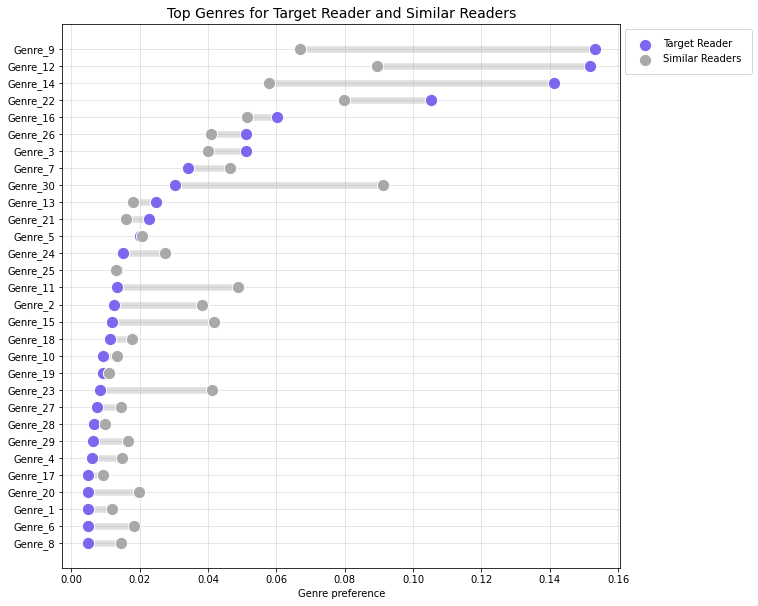

In [308]:
# Show top genres
plot_top_genres(svd_neighborhood_ratings, target_user_ratings)

In [357]:
# Get top recs from predictions
def get_recs(preds, target_reader, book_ind, books, write_to_excel=False):
    
    target_pred_books = preds[preds["index"] == target_reader].columns[1:]
    target_pred_ratings = preds[preds["index"] == target_reader].values[0][1:] * float(row_norms[target])

    # Put into df with relevant info from df_books
    top_preds = pd.DataFrame({"book_index":target_pred_books, "predicted_rating":target_pred_ratings})\
                    .sort_values(by="predicted_rating", ascending=False)\
                    .merge(book_ind.reset_index(), left_on="book_index", right_on="index")\
                    .merge(
                        books[["book_id", "title", "avg_rating", "ratings_count", "year", "main_genre","url"]],
                        on="book_id"
                    )\
                    .drop(columns=["index"])

    # Filter out already read books
    top_preds = top_preds[~top_preds["book_index"].isin(target_user_ratings["book_index"].unique())]
    top_preds.drop(["book_index"], axis=1, inplace=True)

    if write_to_excel == True:
        # Write to excel
        path = wd + "/Web App/data/book_recs.xlsx"
        if os.path.isfile(path):
            with pd.ExcelWriter(path, engine="openpyxl", mode="a", if_sheet_exists='replace') as writer:
                top_preds.query("avg_rating > 3.75").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        else:
            with pd.ExcelWriter(path) as writer:
                top_preds.query("avg_rating > 3.75").drop(columns=["predicted_rating", "main_genre"])\
                    .head(50).to_excel(writer, sheet_name="Top by Predicted Score", index=False)
        writer.close

    return top_preds

In [365]:
# View books with highest target user predicted score
top_preds = get_recs(df_preds, target, book_index, df_books, write_to_excel=False)
top_preds["predicted_rating"] = round(top_preds["predicted_rating"] + svd_neighborhood_ratings["user_rating"].mean(), 2)
top_preds[["title","avg_rating","predicted_rating","ratings_count","year","url"]]\
                .query("avg_rating > 3.5").head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
31,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.10,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
34,11/22/63,4.29,4.05,265669.0,2011.0,https://www.goodreads.com/book/show/10644930-1...
36,The Catcher in the Rye,3.79,4.02,2086945.0,2001.0,https://www.goodreads.com/book/show/5107.The_C...
37,"Binti (Binti, #1)",4.02,4.01,7945.0,2015.0,https://www.goodreads.com/book/show/25667918-b...
40,Les Misérables,4.14,3.97,519758.0,1987.0,https://www.goodreads.com/book/show/24280.Les_...
42,"I, Robot (Robot #0.1)",4.17,3.94,201196.0,2004.0,https://www.goodreads.com/book/show/41804.I_Robot
43,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,3.93,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
44,One Hundred Years of Solitude,4.04,3.92,497852.0,2003.0,https://www.goodreads.com/book/show/320.One_Hu...
45,The Count of Monte Cristo,4.22,3.92,564778.0,2003.0,https://www.goodreads.com/book/show/7126.The_C...
46,Good Omens: The Nice and Accurate Prophecies o...,4.25,3.92,307430.0,2006.0,https://www.goodreads.com/book/show/12067.Good...


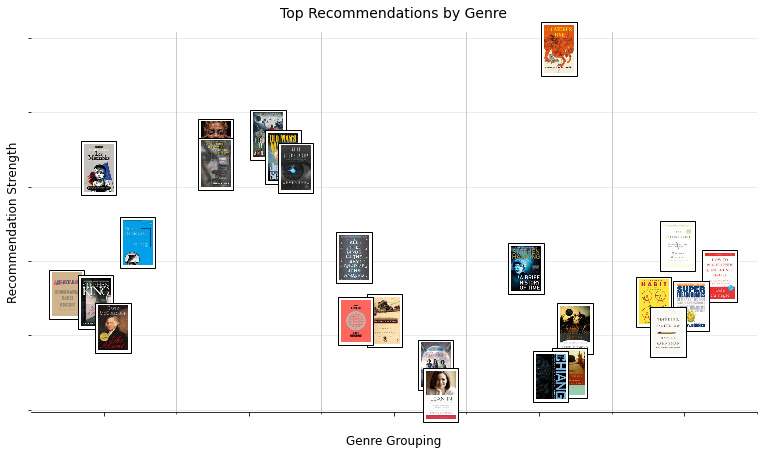

In [311]:
# Display top preds
display_top_books(top_preds, df_books, target_user_ratings)

In [312]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(svd_neighborhood_ratings, n=50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,similar_usr_avg,ratings_count,year,%_similar_usr_read,url
10544,The Martian,4.39,4.28,435440.0,2014.0,10.3%,https://www.goodreads.com/book/show/18007564-t...
6996,Ready Player One,4.31,4.15,376328.0,2011.0,8.8%,https://www.goodreads.com/book/show/9969571-re...
10034,"The Hunger Games (The Hunger Games, #1)",4.34,3.90,4899965.0,2008.0,6.4%,https://www.goodreads.com/book/show/2767052-th...
9514,The Fault in Our Stars,4.26,3.99,2429317.0,2012.0,5.9%,https://www.goodreads.com/book/show/11870085-t...
10739,The Name of the Wind (The Kingkiller Chronicle...,4.55,4.28,416634.0,2007.0,5.9%,https://www.goodreads.com/book/show/186074.The...
893,Animal Farm,3.88,4.35,1928931.0,2003.0,5.7%,https://www.goodreads.com/book/show/7613.Anima...
9739,The Girl on the Train,3.88,3.22,1076144.0,2015.0,5.5%,https://www.goodreads.com/book/show/22557272-t...
9900,The Handmaid's Tale,4.07,3.96,648783.0,1998.0,4.3%,https://www.goodreads.com/book/show/38447.The_...
8709,The Book Thief,4.36,4.32,1193697.0,2005.0,4.3%,https://www.goodreads.com/book/show/19063.The_...
9839,The Great Gatsby,3.89,3.81,2758812.0,2004.0,4.3%,https://www.goodreads.com/book/show/4671.The_G...


In [313]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(svd_neighborhood_ratings, n=50, write_to_excel=False)
top_rated.head(25)

,title,avg_rating,similar_usr_avg,ratings_count,year,url
9402,The Orphan Master's Son,4.06,4.79,54592.0,2012.0,https://www.goodreads.com/book/show/11529868-t...
1432,Bridge of Birds (The Chronicles of Master Li a...,4.30,4.67,8063.0,1985.0,https://www.goodreads.com/book/show/15177.Brid...
10463,"The Way of Kings (The Stormlight Archive, #1)",4.64,4.65,151473.0,2010.0,https://www.goodreads.com/book/show/7235533-th...
3203,Gone with the Wind,4.28,4.64,887935.0,1999.0,https://www.goodreads.com/book/show/18405.Gone...
181,A Fine Balance,4.34,4.58,100539.0,2001.0,https://www.goodreads.com/book/show/5211.A_Fin...
324,A Moveable Feast,4.04,4.57,71261.0,2012.0,https://www.goodreads.com/book/show/4631.A_Mov...
3522,Homegoing,4.41,4.56,49315.0,2016.0,https://www.goodreads.com/book/show/27071490-h...
8703,The Importance of Being Earnest,4.17,4.55,216590.0,1895.0,https://www.goodreads.com/book/show/92303.The_...
10967,"Unbroken: A World War II Story of Survival, Re...",4.39,4.51,504961.0,2010.0,https://www.goodreads.com/book/show/8664353-un...
11296,When Breath Becomes Air,4.32,4.51,131915.0,2016.0,https://www.goodreads.com/book/show/25899336-w...


In [314]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    svd_neighborhood_ratings, 
    preds=top_preds, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=4, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Les Misérables,4.14,4.47,519758.0,1987.0,https://www.goodreads.com/book/show/24280.Les_...
1,Americanah,4.26,3.97,118938.0,2013.0,https://www.goodreads.com/book/show/15796700-a...
2,On Writing: A Memoir of the Craft,4.31,4.37,135528.0,2002.0,https://www.goodreads.com/book/show/10569.On_W...
3,John Adams,4.05,4.50,223171.0,2001.0,https://www.goodreads.com/book/show/2203.John_...
4,The Underground Railroad,4.03,3.87,86839.0,2016.0,https://www.goodreads.com/book/show/30555488-t...
5,The Boys in the Boat: Nine Americans and Their...,4.33,4.39,118259.0,2013.0,https://www.goodreads.com/book/show/16158542-t...
6,"Unbroken: A World War II Story of Survival, Re...",4.39,4.51,504961.0,2010.0,https://www.goodreads.com/book/show/8664353-un...
7,The Picture of Dorian Gray,4.06,4.04,607145.0,1998.0,https://www.goodreads.com/book/show/5297.The_P...
8,A Thousand Splendid Suns,4.34,4.03,835172.0,2007.0,https://www.goodreads.com/book/show/128029.A_T...
9,World War Z: An Oral History of the Zombie War,4.01,3.95,320129.0,2006.0,https://www.goodreads.com/book/show/8908.World...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Binti (Binti, #1)",4.02,3.93,7945.0,2015.0,https://www.goodreads.com/book/show/25667918-b...
1,"Old Man's War (Old Man's War, #1)",4.23,3.94,100702.0,2007.0,https://www.goodreads.com/book/show/51964.Old_...
2,Do Androids Dream of Electric Sheep?,4.08,4.00,229370.0,1996.0,https://www.goodreads.com/book/show/7082.Do_An...
3,"I, Robot (Robot #0.1)",4.17,4.18,201196.0,2004.0,https://www.goodreads.com/book/show/41804.I_Robot
4,"Leviathan Wakes (The Expanse, #1)",4.20,3.99,72492.0,2011.0,https://www.goodreads.com/book/show/8855321-le...
5,Childhood's End,4.09,4.05,89107.0,1953.0,https://www.goodreads.com/book/show/414999.Chi...
6,"The Long Way to a Small, Angry Planet (Wayfare...",4.18,4.07,15139.0,2014.0,https://www.goodreads.com/book/show/22733729-t...
7,The Moon is a Harsh Mistress,4.17,3.82,81655.0,2005.0,https://www.goodreads.com/book/show/16690.The_...
8,Anathem,4.18,4.05,45672.0,2008.0,https://www.goodreads.com/book/show/2845024-an...
9,"The Forever War (The Forever War, #1)",4.15,3.96,89663.0,2003.0,https://www.goodreads.com/book/show/21611.The_...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Blood Meridian, or the Evening Redness in the ...",4.18,4.00,72755.0,1992.0,https://www.goodreads.com/book/show/394535.Blo...
1,"Elon Musk: Tesla, SpaceX, and the Quest for a ...",4.24,4.29,11750.0,2015.0,https://www.goodreads.com/book/show/22535480-e...
2,"Daemon (Daemon, #1)",4.17,3.45,18162.0,NaN,https://www.goodreads.com/book/show/4699575-da...
3,Fuzzy Nation,4.10,4.17,17539.0,2011.0,https://www.goodreads.com/book/show/9647532-fu...
4,Elon Musk: Inventing the Future,4.24,4.06,63849.0,2015.0,https://www.goodreads.com/book/show/22543496-e...
5,The New Jim Crow: Mass Incarceration in the Ag...,4.49,4.55,24694.0,2010.0,https://www.goodreads.com/book/show/6792458-th...
6,The Big Short: Inside the Doomsday Machine,4.26,4.18,37174.0,2010.0,https://www.goodreads.com/book/show/6463967-th...
7,Seabiscuit: An American Legend,4.20,4.00,113228.0,1999.0,https://www.goodreads.com/book/show/110737.Sea...
8,Genghis Khan and the Making of the Modern World,4.01,3.92,26700.0,2004.0,https://www.goodreads.com/book/show/93426.Geng...
9,Cultures and Organizations: Software of the Mind,4.08,5.00,443.0,2004.0,https://www.goodreads.com/book/show/466760.Cul...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,A Brief History of Time,4.13,4.20,173373.0,1998.0,https://www.goodreads.com/book/show/3869.A_Bri...
1,The Unbearable Lightness of Being,4.08,3.69,209734.0,2009.0,https://www.goodreads.com/book/show/9717.The_U...
2,Stories of Your Life and Others,4.27,4.29,17769.0,2010.0,https://www.goodreads.com/book/show/223380.Sto...
3,"The Diamond Age: or, A Young Lady's Illustrate...",4.19,3.87,62866.0,2000.0,https://www.goodreads.com/book/show/827.The_Di...
4,Watchmen,4.35,4.34,406669.0,2005.0,https://www.goodreads.com/book/show/472331.Wat...
5,The Sixth Extinction: An Unnatural History,4.10,3.90,22329.0,2014.0,https://www.goodreads.com/book/show/17910054-t...
6,Eating Animals,4.18,4.36,44149.0,2009.0,https://www.goodreads.com/book/show/6604712-ea...
7,The Left Hand of Darkness,4.05,3.72,63749.0,2000.0,https://www.goodreads.com/book/show/18423.The_...
8,The Idiot,4.18,3.92,76392.0,2003.0,https://www.goodreads.com/book/show/12505.The_...
9,The Master and Margarita,4.32,3.90,136321.0,1996.0,https://www.goodreads.com/book/show/117833.The...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,How to Win Friends and Influence People,4.14,4.02,296690.0,1998.0,https://www.goodreads.com/book/show/4865.How_t...
1,The Power of Habit: Why We Do What We Do in Li...,4.03,4.02,160604.0,2012.0,https://www.goodreads.com/book/show/12609433-t...
2,"Thinking, Fast and Slow",4.09,4.24,144569.0,2011.0,https://www.goodreads.com/book/show/11468377-t...
3,"Creativity, Inc.: Overcoming the Unseen Forces...",4.24,4.32,27705.0,2014.0,https://www.goodreads.com/book/show/18077903-c...
4,Deep Work: Rules for Focused Success in a Dist...,4.19,4.22,15605.0,2016.0,https://www.goodreads.com/book/show/25744928-d...
5,The Elements of Style,4.20,4.29,46765.0,1918.0,https://www.goodreads.com/book/show/33514.The_...
6,Influence: The Psychology of Persuasion,4.18,4.23,47682.0,2006.0,https://www.goodreads.com/book/show/28815.Infl...
7,Hunger: A Memoir of (My) Body,4.31,4.30,15334.0,2017.0,https://www.goodreads.com/book/show/22813605-h...
8,The End of Eternity,4.21,4.20,27229.0,1971.0,https://www.goodreads.com/book/show/509784.The...
9,The Selfish Gene,4.12,4.26,98053.0,1976.0,https://www.goodreads.com/book/show/61535.The_...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Outlander (Outlander, #1)",4.21,3.32,531055.0,2005.0,https://www.goodreads.com/book/show/10964.Outl...
1,"The Lies of Locke Lamora (Gentleman Bastard, #1)",4.30,4.39,123373.0,2006.0,https://www.goodreads.com/book/show/127455.The...
2,Jane Eyre,4.10,3.96,1207986.0,1847.0,https://www.goodreads.com/book/show/10210.Jane...
3,The Traitor Baru Cormorant (Baru Cormorant #1),4.04,4.03,5025.0,2015.0,https://www.goodreads.com/book/show/23444482-t...
4,The Goblin Emperor,4.05,3.62,12081.0,2014.0,https://www.goodreads.com/book/show/17910048-t...
5,"Elantris (Elantris, #1)",4.17,3.89,100115.0,2006.0,https://www.goodreads.com/book/show/68427.Elan...
6,"Shōgun (Asian Saga, #1)",4.37,4.06,106404.0,2009.0,https://www.goodreads.com/book/show/402093.Sh_gun
7,One Flew Over the Cuckoo's Nest,4.19,4.22,498475.0,1963.0,https://www.goodreads.com/book/show/332613.One...
8,"Fall of Giants (The Century Trilogy, #1)",4.26,3.88,173110.0,2010.0,https://www.goodreads.com/book/show/7315573-fa...
9,The Poisonwood Bible,4.03,4.16,552392.0,2005.0,https://www.goodreads.com/book/show/7244.The_P...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Quiet: The Power of Introverts in a World That...,4.04,4.08,208008.0,2012.0,https://www.goodreads.com/book/show/8520610-quiet
1,Man's Search for Meaning,4.33,4.18,179906.0,2006.0,https://www.goodreads.com/book/show/4069.Man_s...
2,The Prophet,4.23,4.11,145579.0,2010.0,https://www.goodreads.com/book/show/2547.The_P...
3,The Subtle Art of Not Giving a F*ck: A Counter...,4.02,3.52,60032.0,2016.0,https://www.goodreads.com/book/show/28257707-t...
4,Zorba the Greek,4.09,4.55,15758.0,1946.0,https://www.goodreads.com/book/show/53639.Zorb...
5,The Last Lecture,4.25,4.00,245804.0,2008.0,https://www.goodreads.com/book/show/2318271.Th...
6,"Year of Yes: How to Dance It Out, Stand In the...",4.05,4.14,27710.0,2015.0,https://www.goodreads.com/book/show/25690958-y...
7,The 7 Habits of Highly Effective People: Power...,4.05,3.74,330726.0,1989.0,https://www.goodreads.com/book/show/36072.The_...
8,We Should All Be Feminists,4.47,4.50,51354.0,2014.0,https://www.goodreads.com/book/show/22738563-w...
9,The Power of Now: A Guide to Spiritual Enlight...,4.11,4.07,109355.0,1997.0,https://www.goodreads.com/book/show/6708.The_P...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Shoe Dog: A Memoir by the Creator of NIKE,4.44,4.28,27468.0,2016.0,https://www.goodreads.com/book/show/27220736-s...
1,"Surely You're Joking, Mr. Feynman!: Adventures...",4.29,4.12,95353.0,1997.0,https://www.goodreads.com/book/show/5544.Surel...
2,Shrill: Notes from a Loud Woman,4.22,4.29,17212.0,2016.0,https://www.goodreads.com/book/show/29340182-s...
3,You're Never Weird on the Internet,4.14,4.21,29419.0,2015.0,https://www.goodreads.com/book/show/23705512-y...
4,The Guernsey Literary and Potato Peel Pie Society,4.12,3.77,399653.0,2008.0,https://www.goodreads.com/book/show/2728527-th...
5,Breakfast of Champions,4.08,3.73,180318.0,1999.0,https://www.goodreads.com/book/show/4980.Break...
6,Just Kids,4.14,3.83,111092.0,2010.0,https://www.goodreads.com/book/show/341879.Jus...
7,Hamilton: The Revolution,4.47,4.40,26640.0,2016.0,https://www.goodreads.com/book/show/26200563-h...
8,"One Summer: America, 1927",4.06,3.00,27950.0,2013.0,https://www.goodreads.com/book/show/17262366-o...
9,That is All,4.03,3.00,1745.0,2011.0,https://www.goodreads.com/book/show/11065215-t...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Dark Matter,4.10,3.85,75794.0,2016.0,https://www.goodreads.com/book/show/27833670-d...
1,One Hundred Years of Solitude,4.04,3.93,497852.0,2003.0,https://www.goodreads.com/book/show/320.One_Hu...
2,Station Eleven,4.02,3.97,166920.0,2014.0,https://www.goodreads.com/book/show/20170404-s...
3,The Night Circus,4.03,3.94,441272.0,2011.0,https://www.goodreads.com/book/show/9361589-th...
4,All the Light We Cannot See,4.31,4.19,498685.0,2014.0,https://www.goodreads.com/book/show/18143977-a...
5,Blindness,4.08,4.25,100752.0,1999.0,https://www.goodreads.com/book/show/2526.Blind...
6,The Amazing Adventures of Kavalier & Clay,4.17,4.19,149976.0,2000.0,https://www.goodreads.com/book/show/3985.The_A...
7,Hamlet,4.01,4.17,526122.0,2005.0,https://www.goodreads.com/book/show/1420.Hamlet
8,Cloud Atlas,4.01,4.04,155020.0,2004.0,https://www.goodreads.com/book/show/49628.Clou...
9,The Shining,4.18,4.03,804918.0,1980.0,https://www.goodreads.com/book/show/11588.The_...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.20,4.04,940154.0,1995.0,https://www.goodreads.com/book/show/11.The_Hit...
1,Bloodline,4.06,3.92,6476.0,2016.0,https://www.goodreads.com/book/show/27209239-b...
2,At the Mountains of Madness and Other Tales of...,4.25,4.40,19861.0,1931.0,https://www.goodreads.com/book/show/32769.At_t...
3,Saga: Book One,4.70,4.75,4201.0,2014.0,https://www.goodreads.com/book/show/22078240-saga
4,The Paper Menagerie and Other Stories,4.37,4.20,4081.0,2016.0,https://www.goodreads.com/book/show/24885533-t...
5,Nightfall and Other Stories,4.27,4.33,10420.0,1969.0,https://www.goodreads.com/book/show/70771.Nigh...
6,Arcanum Unbounded: The Cosmere Collection,4.54,4.38,6493.0,2016.0,https://www.goodreads.com/book/show/28595941-a...
7,"The Walking Dead, Compendium 2",4.53,4.20,13782.0,2012.0,https://www.goodreads.com/book/show/14744381-t...
8,The Call of Cthulhu and Other Weird Stories,4.25,3.80,26100.0,1999.0,https://www.goodreads.com/book/show/160149.The...
9,"Shakespeare and Company, Paris: A History of t...",4.62,5.00,166.0,2016.0,https://www.goodreads.com/book/show/29937876-s...


_____



### 2.3 Matrix Factorization with Gradient Descent

In section [2.3](#23-matrix-factorization-with-gradient-descent) we use gradient descent to train user and book embedding matrices $P$ and $Q$. We minimize the loss function: $$L = (r_{ij} - \sum_{k=1}^{K} p_{ik}q_{kj})^2 + \frac{\beta}{2}\sum_{k=1}^{K}(||P||^2 + ||Q||^2)$$ for all $r_{ij} > 0$ using alternating least squares. After training, we reconstruct $R$ matrix by multiplyting $P * Q$. See [here](http://www.quuxlabs.com/blog/2010/09/matrix-factorization-a-simple-tutorial-and-implementation-in-python/) for a helpful description of the math.

The advantage of gradient descent is that we can train the model on nonzero ratings (i.e. only for books users have actually rated) and apply it to unread books, which yields realistic rating predictions. The downside is that it is computationally very expensive. Larger user-raing $R$ matrices have exponentially more values than smaller ones, so there is a limit to how many nearest neighbors we can use to generate the full set of book ratings to consider. 

In [315]:
# Choose neighborhood size for GD
gd_neighborhoodhood_ratings = med_neighborhood_ratings

In [316]:
# Get unique users and books to slice df_reviews
gd_neighborhood_index = gd_neighborhoodhood_ratings["uid"].unique()
gd_neighborhood_index = np.append(gd_neighborhood_index, target)
gd_neighborhood_book_index = gd_neighborhoodhood_ratings["book_index"].unique()
gd_neighborhood_book_index = np.append(gd_neighborhood_book_index, target_user_ratings["book_index"].unique())
print(f"Neighborhood contains {gd_neighborhood_book_index.shape[0]:,} books")

# Slice df_reviews to make User Ratings Matrix
R = df_reviews[:, gd_neighborhood_book_index]
R = R[gd_neighborhood_index, :]
R = R.toarray()

Neighborhood contains 6,421 books


In [317]:
# Function to train embedding matrices using alternating least squares (ALS) and make predictions 
def matrix_factorization(R, k_components=15, steps=200, lr=0.0002, beta=0.01, decay=True, verbose=0):
    """
    Uses gradient descent to train matrix factorization algorithm

    Args:
        R: Utility matrix of user item ratings         
        k: Number of latent features
        steps: Number of epochs to run training
        lr: Learning rate
        beta: Regularization strength
        verbose: Prints updates if 1

    Returns:
        Predictions, User Embeddings, Item Embdeddings
    """

    # Initialize random values for user (P) and book (Q) embedding matrices    
    P = np.random.rand(R.shape[0],k_components)
    Q = np.random.rand(R.shape[1],k_components).T

    # Get nonzero ratings to perform operations on
    r_0 = np.where(R > 0) # Find indices where rating > 0
    i = r_0[0] # Get row indices where rating > 0
    j = r_0[1] # Get column indices where rating > 0 
    nonzero_ratings = R[i,j]

    # For each step calc residual and take step down gradient
    for step in range(steps): 
        resid = nonzero_ratings - (P @ Q)[i,j] # residual is value - r_hat       
        for k in range(k_components): # for each component (latent feature)                
            P[i,k] = P[i,k] + lr * (2 * resid * Q[k,j] - beta * P[i,k]) # Update P by step in gradient                             
            Q[k,j] = Q[k,j] + lr * (2 * resid * P[i,k] - beta * Q[k,j]) # Update Q by step in gradient                    

        # Calculate error every n steps                  
        if (((step + 1) / (steps / 5)) % 1 == 0) | (step == 0):                                  
            error = np.sum(pow(resid, 2)) + (beta/2) * np.linalg.norm(P,2) + np.linalg.norm(Q,2)
            
            # View progress
            if verbose == 1:
                print(f"Step: {step + 1}, Loss: {error:.2f}, lr: {lr:.5f}") 
            
            # Set learning rate to decay until 0.00002
            if decay == True:
                if lr > 0.00002:                                
                    lr = lr / 1.5
    
    # Get predictions
    preds = np.dot(P, Q)

    return preds, P, Q.T

In [318]:
# Train model and get predictions
preds, user_embed, item_embed = matrix_factorization(
                                    R, 
                                    k_components=45, 
                                    lr=0.02, 
                                    beta=1,
                                    decay=True, 
                                    steps=700, 
                                    verbose=1
                                )
df_preds_GD = pd.DataFrame(preds, columns=gd_neighborhood_book_index, index=gd_neighborhood_index)\
                .reset_index()

Step: 1, Loss: 1945163.65, lr: 0.02000
Step: 140, Loss: 308.14, lr: 0.01333
Step: 280, Loss: 619.14, lr: 0.00889
Step: 420, Loss: 712.12, lr: 0.00593
Step: 560, Loss: 742.94, lr: 0.00395
Step: 700, Loss: 755.38, lr: 0.00263


In [319]:
# View top predicted ratings
top_preds_GD = get_recs(df_preds_GD, target, book_index, df_books, write_to_excel=False)
top_genres = list(pd.DataFrame(target_user_ratings.loc[:, "Genre_1":].sum(axis=0)\
                            .sort_values(ascending=False)).rename(columns={0:"target"})[0:5].index)
top_genres = [int(g[6:]) for g in top_genres]
top_preds_GD.query("avg_rating > 3.75 and ratings_count > 1000 and main_genre in @top_genres")\
    [["title","avg_rating","predicted_rating","ratings_count","year","url"]].head(20)

,title,avg_rating,predicted_rating,ratings_count,year,url
3,"Rendezvous with Rama (Rama, #1)",4.06,0.320524,94581.0,2000.0,https://www.goodreads.com/book/show/112537.Ren...
5,Macbeth,3.88,0.319917,502298.0,1606.0,https://www.goodreads.com/book/show/8852.Macbeth
7,A Brief History of Time,4.13,0.318088,173373.0,1998.0,https://www.goodreads.com/book/show/3869.A_Bri...
10,Inverting the Pyramid: The History of Football...,4.15,0.316724,4682.0,2008.0,https://www.goodreads.com/book/show/3621358-in...
17,Child of All Nations,4.34,0.313603,2382.0,1975.0,https://www.goodreads.com/book/show/248069.Chi...
20,Emergency: This Book Will Save Your Life,3.80,0.312636,3829.0,2009.0,https://www.goodreads.com/book/show/5507552-em...
21,Faust: First Part,3.93,0.311982,43801.0,1988.0,https://www.goodreads.com/book/show/14706.Faust
24,Ignore Everybody: and 39 Other Keys to Creativity,3.93,0.311745,10839.0,2009.0,https://www.goodreads.com/book/show/6162567-ig...
31,The True Believer: Thoughts on the Nature of M...,4.23,0.307483,3244.0,2010.0,https://www.goodreads.com/book/show/15916.The_...
35,La metamorfosis,3.79,0.306473,6543.0,NaN,https://www.goodreads.com/book/show/59186.La_m...


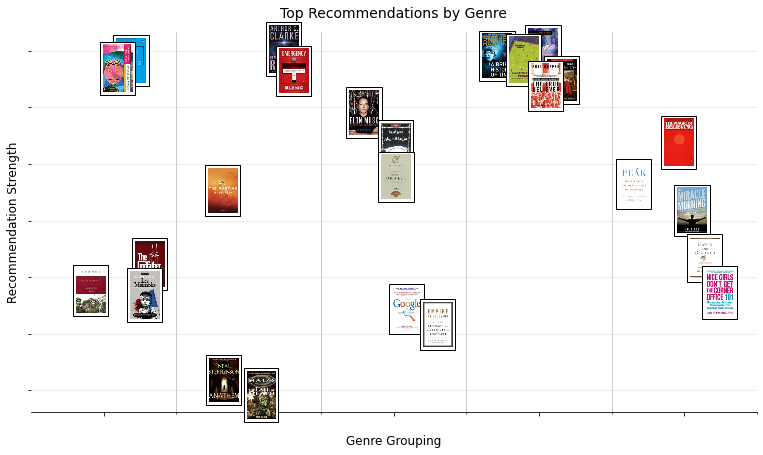

In [320]:
# Display top preds
display_top_books(top_preds_GD, df_books, target_user_ratings)

In [321]:
# View most popular books among neighbors
popular_recs = neighbors_most_popular(gd_neighborhoodhood_ratings, n=50, write_to_excel=False)
popular_recs.head(15)

,title,avg_rating,similar_usr_avg,ratings_count,year,%_similar_usr_read,url
2283,Ready Player One,4.31,4.06,376328.0,2011.0,9.8%,https://www.goodreads.com/book/show/9969571-re...
3479,The Martian,4.39,4.29,435440.0,2014.0,9.1%,https://www.goodreads.com/book/show/18007564-t...
3325,"The Hunger Games (The Hunger Games, #1)",4.34,3.61,4899965.0,2008.0,6.4%,https://www.goodreads.com/book/show/2767052-th...
3536,The Name of the Wind (The Kingkiller Chronicle...,4.55,4.38,416634.0,2007.0,5.5%,https://www.goodreads.com/book/show/186074.The...
3205,The Girl on the Train,3.88,3.35,1076144.0,2015.0,4.7%,https://www.goodreads.com/book/show/22557272-t...
267,"American Gods (American Gods, #1)",4.11,3.95,379668.0,2005.0,4.6%,https://www.goodreads.com/book/show/4407.Ameri...
536,Brave New World,3.97,3.84,1043619.0,1998.0,4.5%,https://www.goodreads.com/book/show/5129.Brave...
299,"Ancillary Justice (Imperial Radch, #1)",3.97,3.97,40736.0,2013.0,4.3%,https://www.goodreads.com/book/show/17333324-a...
2061,"Old Man's War (Old Man's War, #1)",4.23,3.91,100702.0,2007.0,4.0%,https://www.goodreads.com/book/show/51964.Old_...
3727,The Road,3.95,3.79,513565.0,2006.0,4.0%,https://www.goodreads.com/book/show/6288.The_Road


In [322]:
# Highest rated books among similar readers
top_rated = neighbors_top_rated(gd_neighborhoodhood_ratings, n=50, write_to_excel=False)
top_rated.head(20)

,title,avg_rating,similar_usr_avg,ratings_count,year,url
463,Bridge of Birds (The Chronicles of Master Li a...,4.30,4.83,8063.0,1985.0,https://www.goodreads.com/book/show/15177.Brid...
2809,The Importance of Being Earnest,4.17,4.80,216590.0,1895.0,https://www.goodreads.com/book/show/92303.The_...
1751,One Flew Over the Cuckoo's Nest,4.19,4.75,498475.0,1963.0,https://www.goodreads.com/book/show/332613.One...
1461,Lonesome Dove,4.47,4.67,113308.0,1999.0,https://www.goodreads.com/book/show/256008.Lon...
1606,Mother Night,4.21,4.62,53698.0,1961.0,https://www.goodreads.com/book/show/9592.Mothe...
3544,"Unbroken: A World War II Story of Survival, Re...",4.39,4.60,504961.0,2010.0,https://www.goodreads.com/book/show/8664353-un...
2680,The Gene: An Intimate History,4.36,4.60,9874.0,2016.0,https://www.goodreads.com/book/show/27276428-t...
3116,"The Red Knight (The Traitor Son Cycle, #1)",4.12,4.60,8906.0,2012.0,https://www.goodreads.com/book/show/13616278-t...
3617,We,3.95,4.60,40890.0,1993.0,https://www.goodreads.com/book/show/76171.We
1258,Infinite Jest,4.31,4.57,47926.0,2005.0,https://www.goodreads.com/book/show/6759.Infin...


In [323]:
# Highest rated books by each of the top genres
show_top_recs_by_genre(
    target_user_ratings, 
    gd_neighborhoodhood_ratings, 
    preds=top_preds_GD, 
    how="MF", 
    whose_genres="target", 
    n_genres=10, 
    min_score=3.75, 
    n_recs=20,
    write_to_excel=False
)

Genre 9: ['war', 'history', 'account', 'family', 'year', 'young', 'world', 'time', 'memoir', 'portrait']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Child of All Nations,4.34,5.00,2382.0,1975.0,https://www.goodreads.com/book/show/248069.Chi...
1,The Wall,4.07,4.50,12523.0,2005.0,https://www.goodreads.com/book/show/10031.The_...
2,Beyond the Horizon,3.87,4.00,123.0,1995.0,https://www.goodreads.com/book/show/738841.Bey...
3,Down and Out in Paris and London,4.10,4.00,35742.0,1972.0,https://www.goodreads.com/book/show/393199.Dow...
4,The Godfather,4.36,4.22,259150.0,2002.0,https://www.goodreads.com/book/show/22034.The_...
5,Homage to Catalonia,4.14,3.50,23122.0,1980.0,https://www.goodreads.com/book/show/9646.Homag...
6,Les Misérables,4.14,4.00,519758.0,1987.0,https://www.goodreads.com/book/show/24280.Les_...
7,The House of the Dead,4.04,4.00,8548.0,2004.0,https://www.goodreads.com/book/show/17877.The_...
8,The Dream of a Ridiculous Man,4.07,4.00,4927.0,1877.0,https://www.goodreads.com/book/show/329866.The...
9,An Unquiet Mind: A Memoir of Moods and Madness,4.03,3.75,41959.0,1996.0,https://www.goodreads.com/book/show/361459.An_...


_____

Genre 12: ['alien', 'planet', 'world', 'human', 'space', 'war', 'galaxy', 'race', 'ship', 'humanity']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Rendezvous with Rama (Rama, #1)",4.06,3.44,94581.0,2000.0,https://www.goodreads.com/book/show/112537.Ren...
1,Emergency: This Book Will Save Your Life,3.80,4.00,3829.0,2009.0,https://www.goodreads.com/book/show/5507552-em...
2,"Red Mars (Mars Trilogy, #1)",3.84,3.50,47269.0,1993.0,https://www.goodreads.com/book/show/77507.Red_...
3,The Martian,4.39,4.29,435440.0,2014.0,https://www.goodreads.com/book/show/18007564-t...
4,Anathem,4.18,4.07,45672.0,2008.0,https://www.goodreads.com/book/show/2845024-an...
5,Halo: The Fall of Reach,4.26,5.00,14823.0,2001.0,https://www.goodreads.com/book/show/60229.Halo
6,"Parable of the Sower (Earthseed, #1)",4.14,4.00,26932.0,2000.0,https://www.goodreads.com/book/show/52397.Para...
7,The Abyss Beyond Dreams,4.21,4.00,4944.0,2014.0,https://www.goodreads.com/book/show/20697413-t...
8,"A World Out of Time (The State, #1)",3.80,5.00,4031.0,1986.0,https://www.goodreads.com/book/show/64725.A_Wo...
9,Dirk Gently's Holistic Detective Agency (Dirk ...,3.97,3.50,91027.0,1991.0,https://www.goodreads.com/book/show/365.Dirk_G...


_____

Genre 14: ['political', 'history', 'world', 'economic', 'government', 'global', 'politics', 'social', 'country', 'financial']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Elon Musk: Inventing the Future,4.24,4.00,63849.0,2015.0,https://www.goodreads.com/book/show/22543496-e...
1,Onward: How Starbucks Fought for Its Life with...,3.79,4.00,11574.0,2011.0,https://www.goodreads.com/book/show/9151181-on...
2,مزرعة الحيوان,3.88,4.00,756.0,NaN,https://www.goodreads.com/book/show/21947735
3,Animal Farm / 1984,4.26,4.67,120269.0,2003.0,https://www.goodreads.com/book/show/5472.Anima...
4,How an Economy Grows and Why It Crashes,4.13,4.00,2224.0,2010.0,https://www.goodreads.com/book/show/7048818-ho...
5,"The Google Story: Inside the Hottest Business,...",3.82,4.00,11371.0,2008.0,https://www.goodreads.com/book/show/164323.The...
6,Empire of Illusion: The End of Literacy and th...,3.94,4.00,3512.0,2009.0,https://www.goodreads.com/book/show/6577631-em...
7,Hidden Figures: The American Dream and the Unt...,3.92,4.00,24753.0,2016.0,https://www.goodreads.com/book/show/25953369-h...
8,Post-Capitalist Society,4.05,5.00,198.0,1994.0,https://www.goodreads.com/book/show/1083152.Po...
9,The Little Book That Builds Wealth: The Knocko...,4.24,5.00,778.0,2008.0,https://www.goodreads.com/book/show/2389174.Th...


_____

Genre 22: ['history', 'poem', 'text', 'introduction', 'writing', 'science', 'translation', 'literature', 'essay', 'modern']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Macbeth,3.88,4.33,502298.0,1606.0,https://www.goodreads.com/book/show/8852.Macbeth
1,A Brief History of Time,4.13,4.25,173373.0,1998.0,https://www.goodreads.com/book/show/3869.A_Bri...
2,Inverting the Pyramid: The History of Football...,4.15,4.00,4682.0,2008.0,https://www.goodreads.com/book/show/3621358-in...
3,Faust: First Part,3.93,3.50,43801.0,1988.0,https://www.goodreads.com/book/show/14706.Faust
4,"Early Modern Europe, 1450-1789",3.87,5.00,124.0,2006.0,https://www.goodreads.com/book/show/201539.Ear...
5,The True Believer: Thoughts on the Nature of M...,4.23,4.50,3244.0,2010.0,https://www.goodreads.com/book/show/15916.The_...
6,La metamorfosis,3.79,4.00,6543.0,NaN,https://www.goodreads.com/book/show/59186.La_m...
7,Pride and Prejudice,4.25,4.43,2078406.0,2000.0,https://www.goodreads.com/book/show/1885.Pride...
8,Chasers of the Light: Poems from the Typewrite...,4.27,4.00,6690.0,2014.0,https://www.goodreads.com/book/show/20821097-c...
9,The Catcher in the Rye,3.79,3.44,2086945.0,2001.0,https://www.goodreads.com/book/show/5107.The_C...


_____

Genre 16: ['guide', 'help', 'health', 'technique', 'way', 'practical', 'advice', 'people', 'business', 'learn']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,All Marketers Are Liars: The Underground Class...,3.89,4.00,152.0,NaN,https://www.goodreads.com/book/show/6976036-al...
1,Ignore Everybody: and 39 Other Keys to Creativity,3.93,5.00,10839.0,2009.0,https://www.goodreads.com/book/show/6162567-ig...
2,Every Patient Tells a Story: Medical Mysteries...,3.91,4.00,4093.0,2009.0,https://www.goodreads.com/book/show/6691125-ev...
3,The Magic of Believing,4.22,5.00,2935.0,1991.0,https://www.goodreads.com/book/show/968009.The...
4,Peak: Secrets from the New Science of Expertise,4.31,4.00,3084.0,2016.0,https://www.goodreads.com/book/show/26312997-peak
5,The Miracle Morning: The Not-So-Obvious Secret...,3.98,3.00,11294.0,2006.0,https://www.goodreads.com/book/show/17166225-t...
6,"David and Goliath: Underdogs, Misfits, and the...",3.90,4.33,93028.0,2013.0,https://www.goodreads.com/book/show/15751404-d...
7,The Happiest Baby on the Block: The New Way to...,3.92,3.33,13295.0,2005.0,https://www.goodreads.com/book/show/132900.The...
8,Nice Girls Don't Get the Corner Office: 101 Un...,3.77,3.00,6728.0,2010.0,https://www.goodreads.com/book/show/97641.Nice...
9,The Power of Habit: Why We Do What We Do in Li...,4.03,4.25,160604.0,2012.0,https://www.goodreads.com/book/show/12609433-t...


_____

Genre 26: ['war', 'king', 'throne', 'family', 'young', 'world', 'royal', 'court', 'power', 'kingdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Jane Eyre,4.10,4.00,1207986.0,1847.0,https://www.goodreads.com/book/show/10210.Jane...
1,One Flew Over the Cuckoo's Nest,4.19,4.75,498475.0,1963.0,https://www.goodreads.com/book/show/332613.One...
2,"Seraphina (Seraphina, #1)",3.98,5.00,34791.0,2013.0,https://www.goodreads.com/book/show/19549841-s...
3,"Outlander (Outlander, #1)",4.21,2.89,531055.0,2005.0,https://www.goodreads.com/book/show/10964.Outl...
4,Shōgun,4.37,5.00,4818.0,1975.0,https://www.goodreads.com/book/show/38044.Sh_gun
5,The Age of Innocence,3.93,3.00,104158.0,2004.0,https://www.goodreads.com/book/show/53835.The_...
6,Gates of Fire: An Epic Novel of the Battle of ...,4.40,4.75,18299.0,2005.0,https://www.goodreads.com/book/show/1305.Gates...
7,"Assassin's Apprentice (Farseer Trilogy, #1)",4.14,3.95,133239.0,1996.0,https://www.goodreads.com/book/show/45107.Assa...
8,The 48 Laws of Power,4.18,2.80,39588.0,2000.0,https://www.goodreads.com/book/show/1303.The_4...
9,The Silmarillion,3.88,4.00,136721.0,2004.0,https://www.goodreads.com/book/show/7332.The_S...


_____

Genre 3: ['spiritual', 'faith', 'people', 'experience', 'church', 'way', 'world', 'question', 'personal', 'wisdom']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Forty Rules of Love,4.17,4.00,36814.0,2010.0,https://www.goodreads.com/book/show/6642715-th...
1,ثم صار المخ عقلًا,4.08,4.00,493.0,NaN,https://www.goodreads.com/book/show/13559213
2,A Grief Observed,4.25,4.50,37061.0,2015.0,https://www.goodreads.com/book/show/49221.A_Gr...
3,Damn Good Advice (For People with Talent!): Ho...,3.89,4.00,2439.0,2012.0,https://www.goodreads.com/book/show/12859410-d...
4,The World According to Mister Rogers: Importan...,4.32,3.00,1795.0,2003.0,https://www.goodreads.com/book/show/73123.The_...
5,How to Be Perfectly Unhappy,3.91,3.00,150.0,2017.0,https://www.goodreads.com/book/show/34536949-h...
6,"Too Like the Lightning (Terra Ignota, #1)",3.87,3.70,2907.0,2016.0,https://www.goodreads.com/book/show/26114545-t...
7,The Last Lecture,4.25,4.25,245804.0,2008.0,https://www.goodreads.com/book/show/2318271.Th...
8,Philosophy for Life: And Other Dangerous Situa...,4.10,1.00,843.0,2012.0,https://www.goodreads.com/book/show/13629522-p...
9,The Sound of Paper,4.00,5.00,923.0,2004.0,https://www.goodreads.com/book/show/498501.The...


_____

Genre 7: ['film', 'music', 'funny', 'movie', 'hilarious', 'year', 'memoir', 'world', 'time', 'star']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,"Backstage Pass (Sinners on Tour, #1)",4.05,4.00,50470.0,2010.0,https://www.goodreads.com/book/show/8379374-ba...
1,Crónica de una muerte anunciada,3.95,4.00,766.0,NaN,https://www.goodreads.com/book/show/31927206-c...
2,"Instrumental: A Memoir of Madness, Medication ...",4.26,4.00,1796.0,2015.0,https://www.goodreads.com/book/show/21896497-i...
3,An Ideal Husband,4.03,4.50,30337.0,2001.0,https://www.goodreads.com/book/show/5296.An_Id...
4,Con đường Hồi giáo,4.36,3.00,1088.0,2014.0,https://www.goodreads.com/book/show/21474711-c...
5,Groucho: The Life and Times of Julius Henry Marx,4.01,3.00,468.0,2001.0,https://www.goodreads.com/book/show/339611.Gro...
6,Save the Cat!: The Last Book on Screenwriting ...,4.05,4.00,7172.0,2005.0,https://www.goodreads.com/book/show/49464.Save...
7,Scrappy Little Nobody,3.90,4.50,32963.0,2016.0,https://www.goodreads.com/book/show/29868610-s...
8,A Streetcar Named Desire,3.97,4.00,202539.0,1952.0,https://www.goodreads.com/book/show/12220.A_St...
9,"The Art of Asking; or, How I Learned to Stop W...",3.97,4.50,20606.0,2014.0,https://www.goodreads.com/book/show/20980987-t...


_____

Genre 30: ['world', 'young', 'family', 'place', 'fiction', 'time', 'year', 'journey', 'house', 'dark']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,Midaq Alley,3.83,4.00,4216.0,1991.0,https://www.goodreads.com/book/show/5499.Midaq...
1,The Gambler,3.88,5.00,22024.0,2003.0,https://www.goodreads.com/book/show/12857.The_...
2,"The Maze Runner (Maze Runner, #1)",4.03,3.36,745820.0,2009.0,https://www.goodreads.com/book/show/6186357-th...
3,One Hundred Years of Solitude,4.04,4.12,497852.0,2003.0,https://www.goodreads.com/book/show/320.One_Hu...
4,Wuthering Heights,3.83,3.12,916820.0,2002.0,https://www.goodreads.com/book/show/6185.Wuthe...
5,All the Light We Cannot See,4.31,4.61,498685.0,2014.0,https://www.goodreads.com/book/show/18143977-a...
6,Death Comes for the Archbishop,3.88,4.00,21673.0,1990.0,https://www.goodreads.com/book/show/545951.Dea...
7,Laughter in the Dark,3.95,3.00,7389.0,2006.0,https://www.goodreads.com/book/show/8151.Laugh...
8,Men Without Women,3.77,3.00,4337.0,NaN,https://www.goodreads.com/book/show/33652490-m...
9,The Great Gatsby,3.89,3.56,2758812.0,2004.0,https://www.goodreads.com/book/show/4671.The_G...


_____

Genre 13: ['collection', 'short', 'comic', 'available', 'novella', 'feature', 'bestselling', 'includes', 'anthology', 'fiction']


,title,avg_rating,similar_usr_avg,ratings_count,year,url
0,The Garden of Forking Paths,4.40,5.00,1326.0,2010.0,https://www.goodreads.com/book/show/10438328-t...
1,The Only Astrology Book You'll Ever Need,4.19,4.00,1448.0,1982.0,https://www.goodreads.com/book/show/120991.The...
2,Stephen Hawking's a Brief History of Time: A R...,4.10,5.00,315.0,1992.0,https://www.goodreads.com/book/show/17352.Step...
3,The Girl With the Dragon Tattoo: Wiki content ...,4.47,4.00,977.0,2011.0,https://www.goodreads.com/book/show/10618633-t...
4,Bloodline,4.06,3.60,6476.0,2016.0,https://www.goodreads.com/book/show/27209239-b...
5,Come Close,3.93,4.00,705.0,2015.0,https://www.goodreads.com/book/show/24874364-c...
6,Pedro Páramo,4.04,3.67,21159.0,1955.0,https://www.goodreads.com/book/show/38787.Pedr...
7,"The Walking Dead, Compendium 2",4.53,3.50,13782.0,2012.0,https://www.goodreads.com/book/show/14744381-t...
8,The Year's Best Science Fiction: Twenty-Eighth...,3.83,4.00,288.0,2011.0,https://www.goodreads.com/book/show/10865914-t...
9,E não sobrou nenhum,4.23,4.00,139.0,NaN,https://www.goodreads.com/book/show/28093104-e...


_____



### Appendix: Find Similar User Ratings by Searching Title

In [324]:
title_search = "Bridge of Birds".lower()

Small Neighborhood
Book not found
__________

Medium Neighborhood


,title,main_genre,avg_rating,sim_reader_avg,count
0,Bridge of Birds (The Chronicles of Master Li a...,30.0,4.3,4.83,6


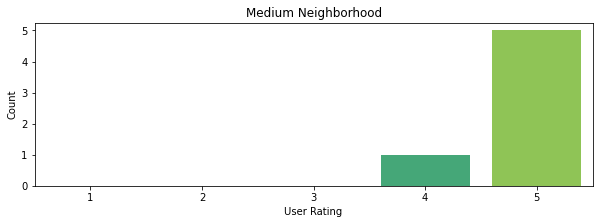

Large Neighborhood


,title,main_genre,avg_rating,sim_reader_avg,count
0,Bridge of Birds (The Chronicles of Master Li a...,30.0,4.3,4.67,15


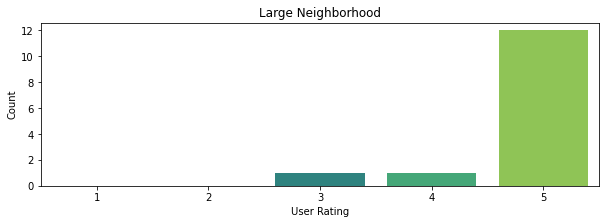

In [325]:
# Search neighborhoods for title_search, get similar user ratings
for i in range(3):
    
    df = [sm_neighborhood_ratings, med_neighborhood_ratings, lg_neighborhood_ratings][i]
    
    if i == 0:
        title = "Small Neighborhood"
        print(title)
    elif i == 1: 
        title = "Medium Neighborhood"
        print(title)
    elif i == 2:
        title = "Large Neighborhood" 
        print(title)

    filtered = df[df["title"].str.lower().str.contains(title_search)]
    grouped = filtered.groupby(["title", "main_genre", "avg_rating"])["user_rating"].agg(["mean","count"])\
                        .reset_index().sort_values(by="count", ascending=False)\
                            .rename(columns={"mean":"sim_reader_avg"})
    grouped["sim_reader_avg"] = grouped["sim_reader_avg"].round(2)

    if len(grouped) > 0:
        
        display(grouped)        
        
        fig, ax = plt.subplots(figsize=(10,3))
        d = filtered["user_rating"]
        score = []
        counts = []
        for i in range(5):
            score.append(i+1)
            counts.append(list(d).count(i+1))
        d = pd.DataFrame({"User Rating":score, "Count":counts})
        
        sns.barplot(
            data=d,
            x="User Rating",
            y="Count",
            palette="viridis"    
        )
        plt.title(title)
        plt.show()
    
    else:
        print("Book not found\n__________\n")        
    
